# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

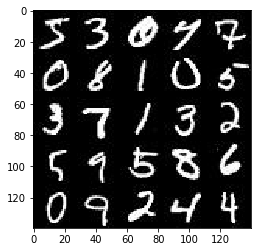

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

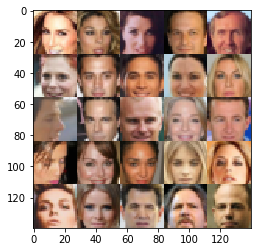

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

c:\users\tracy\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='inputs_z')
    learing_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')
    
    return inputs_real, inputs_z, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [63]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.nn.leaky_relu(x1, alpha=alpha)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.leaky_relu(bn, alpha=alpha)
        # 7x7x256
         
        # Flatten it
        flat = tf.layers.flatten(relu2)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [56]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # desen layer
        d = tf.layers.dense(z, 7*7*256)
        d = tf.reshape(d, (-1,7,7,256))
        d = tf.layers.batch_normalization(d, training=is_train)
        d = tf.nn.leaky_relu(d, alpha=alpha)
        
        # conv1 -> 14 * 14 * 128
        c = tf.layers.conv2d_transpose(d, 128, 5, strides=2, padding='same')
        c = tf.layers.batch_normalization(c, training=is_train)
        c = tf.nn.leaky_relu(c, alpha=alpha)
        
        # last layer -> 28 * 28 * out_channel_dim
        logits = tf.layers.conv2d_transpose(c, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_real_model, d_real_logits = discriminator(input_real)
    d_fake_model, d_fake_logits = discriminator(g_model, reuse=True)    
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_model) * (1 - smooth)
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_model)))
    
    d_loss = d_real_loss + d_fake_loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_model)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    steps = 0
    
    n_images = 25 # numbers of images show every 100 steps
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    inputs_real, inputs_z, learing_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps+=1
                # scale to -1 , 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run discriminator optimizer
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learing_rate:learning_rate})
                # Run genertor optimizer
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, learing_rate:learning_rate})
                
                # print loss every 20 steps
                if (steps % 20 == 0):
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...steps:{}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # show image every 100 steps
                if (steps % 100 == 0):
                    show_generator_output(sess, n_images, inputs_z, image_channels, data_image_mode)
        
        print("Train Finished!")

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2...steps:20 Discriminator Loss: 1.2183... Generator Loss: 0.6500
Epoch 1/2...steps:40 Discriminator Loss: 0.5983... Generator Loss: 2.9784
Epoch 1/2...steps:60 Discriminator Loss: 1.5104... Generator Loss: 0.4723
Epoch 1/2...steps:80 Discriminator Loss: 1.1062... Generator Loss: 2.3657
Epoch 1/2...steps:100 Discriminator Loss: 0.9389... Generator Loss: 1.6600


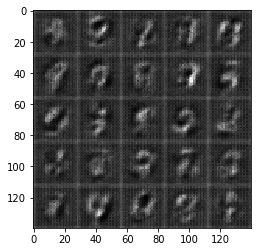

Epoch 1/2...steps:120 Discriminator Loss: 1.1451... Generator Loss: 0.7074
Epoch 1/2...steps:140 Discriminator Loss: 1.1547... Generator Loss: 0.6853
Epoch 1/2...steps:160 Discriminator Loss: 1.1786... Generator Loss: 1.9676
Epoch 1/2...steps:180 Discriminator Loss: 1.1173... Generator Loss: 0.7136
Epoch 1/2...steps:200 Discriminator Loss: 0.9172... Generator Loss: 1.0530


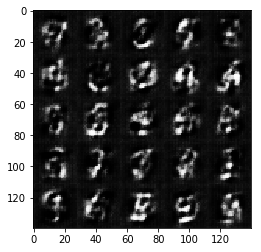

Epoch 1/2...steps:220 Discriminator Loss: 0.9501... Generator Loss: 1.1871
Epoch 1/2...steps:240 Discriminator Loss: 0.8376... Generator Loss: 1.2372
Epoch 1/2...steps:260 Discriminator Loss: 0.8865... Generator Loss: 1.2087
Epoch 1/2...steps:280 Discriminator Loss: 0.9292... Generator Loss: 1.0122
Epoch 1/2...steps:300 Discriminator Loss: 0.8056... Generator Loss: 1.2503


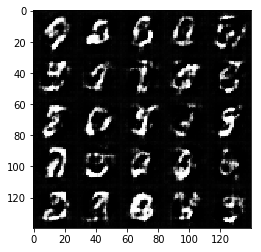

Epoch 1/2...steps:320 Discriminator Loss: 0.8013... Generator Loss: 1.3226
Epoch 1/2...steps:340 Discriminator Loss: 0.8910... Generator Loss: 1.4523
Epoch 1/2...steps:360 Discriminator Loss: 0.7908... Generator Loss: 1.4186
Epoch 1/2...steps:380 Discriminator Loss: 0.7970... Generator Loss: 1.5561
Epoch 1/2...steps:400 Discriminator Loss: 0.7982... Generator Loss: 2.1730


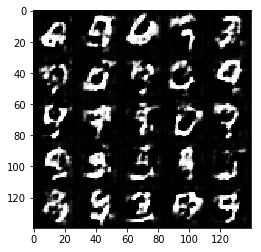

Epoch 1/2...steps:420 Discriminator Loss: 0.9647... Generator Loss: 0.8897
Epoch 1/2...steps:440 Discriminator Loss: 0.7588... Generator Loss: 1.5099
Epoch 1/2...steps:460 Discriminator Loss: 0.7977... Generator Loss: 1.4861
Epoch 2/2...steps:480 Discriminator Loss: 0.7354... Generator Loss: 1.7939
Epoch 2/2...steps:500 Discriminator Loss: 0.7312... Generator Loss: 1.7707


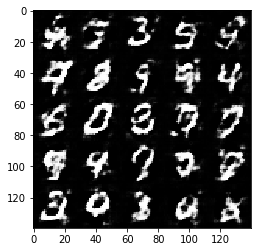

Epoch 2/2...steps:520 Discriminator Loss: 0.7784... Generator Loss: 1.2616
Epoch 2/2...steps:540 Discriminator Loss: 1.0113... Generator Loss: 0.8695
Epoch 2/2...steps:560 Discriminator Loss: 0.7506... Generator Loss: 1.4711
Epoch 2/2...steps:580 Discriminator Loss: 0.9576... Generator Loss: 2.2697
Epoch 2/2...steps:600 Discriminator Loss: 0.8210... Generator Loss: 1.1565


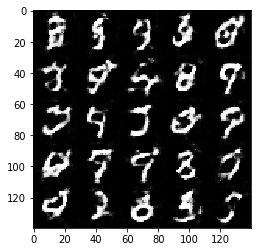

Epoch 2/2...steps:620 Discriminator Loss: 0.7313... Generator Loss: 1.6086
Epoch 2/2...steps:640 Discriminator Loss: 0.8720... Generator Loss: 1.2421
Epoch 2/2...steps:660 Discriminator Loss: 1.0321... Generator Loss: 0.8823
Epoch 2/2...steps:680 Discriminator Loss: 0.9197... Generator Loss: 1.1293
Epoch 2/2...steps:700 Discriminator Loss: 1.0444... Generator Loss: 0.9741


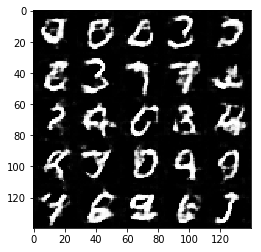

Epoch 2/2...steps:720 Discriminator Loss: 0.8902... Generator Loss: 1.4767
Epoch 2/2...steps:740 Discriminator Loss: 0.9286... Generator Loss: 1.5495
Epoch 2/2...steps:760 Discriminator Loss: 1.0745... Generator Loss: 2.1261
Epoch 2/2...steps:780 Discriminator Loss: 1.0557... Generator Loss: 0.8356
Epoch 2/2...steps:800 Discriminator Loss: 1.0249... Generator Loss: 1.4636


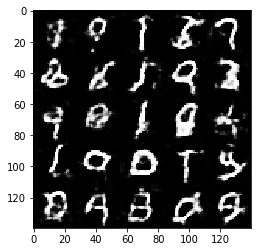

Epoch 2/2...steps:820 Discriminator Loss: 1.0885... Generator Loss: 1.8544
Epoch 2/2...steps:840 Discriminator Loss: 0.8961... Generator Loss: 1.3987
Epoch 2/2...steps:860 Discriminator Loss: 1.0062... Generator Loss: 1.0262
Epoch 2/2...steps:880 Discriminator Loss: 0.9332... Generator Loss: 1.7072
Epoch 2/2...steps:900 Discriminator Loss: 0.9781... Generator Loss: 1.3468


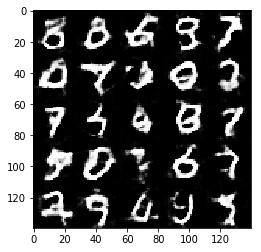

Epoch 2/2...steps:920 Discriminator Loss: 0.9597... Generator Loss: 1.3554
Train Finished!


In [64]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1...steps:20 Discriminator Loss: 0.5782... Generator Loss: 2.3207
Epoch 1/1...steps:40 Discriminator Loss: 0.5516... Generator Loss: 2.2972
Epoch 1/1...steps:60 Discriminator Loss: 1.1548... Generator Loss: 0.7564
Epoch 1/1...steps:80 Discriminator Loss: 1.0248... Generator Loss: 2.0339
Epoch 1/1...steps:100 Discriminator Loss: 1.6625... Generator Loss: 4.1473


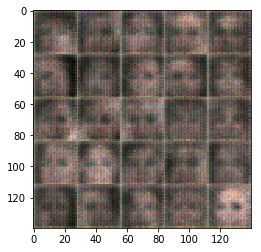

Epoch 1/1...steps:120 Discriminator Loss: 0.8668... Generator Loss: 1.2040
Epoch 1/1...steps:140 Discriminator Loss: 1.2628... Generator Loss: 2.6719
Epoch 1/1...steps:160 Discriminator Loss: 0.9895... Generator Loss: 1.5012
Epoch 1/1...steps:180 Discriminator Loss: 0.9599... Generator Loss: 1.0400
Epoch 1/1...steps:200 Discriminator Loss: 1.2545... Generator Loss: 0.9237


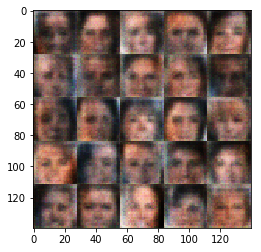

Epoch 1/1...steps:220 Discriminator Loss: 1.3009... Generator Loss: 0.6420
Epoch 1/1...steps:240 Discriminator Loss: 1.7522... Generator Loss: 0.3297
Epoch 1/1...steps:260 Discriminator Loss: 1.1961... Generator Loss: 0.7161
Epoch 1/1...steps:280 Discriminator Loss: 0.9556... Generator Loss: 1.1070
Epoch 1/1...steps:300 Discriminator Loss: 0.8404... Generator Loss: 1.2723


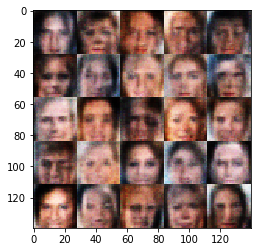

Epoch 1/1...steps:320 Discriminator Loss: 1.0001... Generator Loss: 0.9905
Epoch 1/1...steps:340 Discriminator Loss: 1.6741... Generator Loss: 0.3453
Epoch 1/1...steps:360 Discriminator Loss: 0.7942... Generator Loss: 1.7871
Epoch 1/1...steps:380 Discriminator Loss: 0.9014... Generator Loss: 1.4350
Epoch 1/1...steps:400 Discriminator Loss: 0.7633... Generator Loss: 1.7388


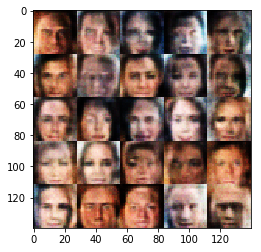

Epoch 1/1...steps:420 Discriminator Loss: 0.8077... Generator Loss: 2.7133
Epoch 1/1...steps:440 Discriminator Loss: 1.2173... Generator Loss: 4.2770
Epoch 1/1...steps:460 Discriminator Loss: 0.9138... Generator Loss: 2.9990
Epoch 1/1...steps:480 Discriminator Loss: 0.6934... Generator Loss: 2.8326
Epoch 1/1...steps:500 Discriminator Loss: 0.7307... Generator Loss: 1.4727


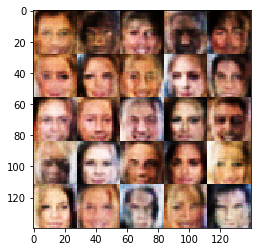

Epoch 1/1...steps:520 Discriminator Loss: 1.7687... Generator Loss: 0.3829
Epoch 1/1...steps:540 Discriminator Loss: 0.6109... Generator Loss: 2.6788
Epoch 1/1...steps:560 Discriminator Loss: 0.8455... Generator Loss: 3.7094
Epoch 1/1...steps:580 Discriminator Loss: 0.7146... Generator Loss: 2.9202
Epoch 1/1...steps:600 Discriminator Loss: 1.1725... Generator Loss: 4.2553


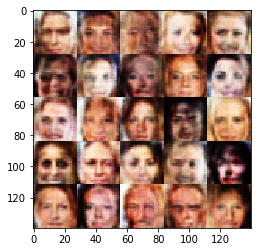

Epoch 1/1...steps:620 Discriminator Loss: 0.9765... Generator Loss: 0.9256
Epoch 1/1...steps:640 Discriminator Loss: 1.0937... Generator Loss: 0.7739
Epoch 1/1...steps:660 Discriminator Loss: 0.7460... Generator Loss: 1.4606
Epoch 1/1...steps:680 Discriminator Loss: 1.3188... Generator Loss: 0.6378
Epoch 1/1...steps:700 Discriminator Loss: 0.6387... Generator Loss: 2.8203


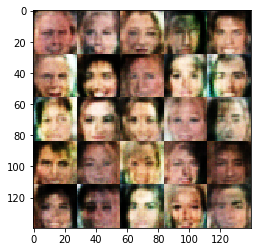

Epoch 1/1...steps:720 Discriminator Loss: 1.1654... Generator Loss: 0.7641
Epoch 1/1...steps:740 Discriminator Loss: 0.9745... Generator Loss: 2.1160
Epoch 1/1...steps:760 Discriminator Loss: 0.9740... Generator Loss: 3.4865
Epoch 1/1...steps:780 Discriminator Loss: 1.1087... Generator Loss: 0.7717
Epoch 1/1...steps:800 Discriminator Loss: 1.1821... Generator Loss: 0.6584


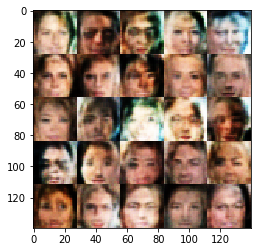

Epoch 1/1...steps:820 Discriminator Loss: 0.4483... Generator Loss: 2.7706
Epoch 1/1...steps:840 Discriminator Loss: 0.6254... Generator Loss: 3.6222
Epoch 1/1...steps:860 Discriminator Loss: 0.7477... Generator Loss: 2.6036
Epoch 1/1...steps:880 Discriminator Loss: 0.8515... Generator Loss: 1.3126
Epoch 1/1...steps:900 Discriminator Loss: 0.5975... Generator Loss: 5.3781


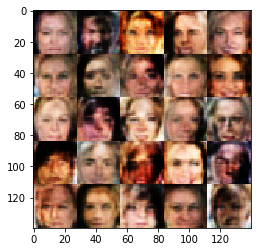

Epoch 1/1...steps:920 Discriminator Loss: 0.5103... Generator Loss: 3.3436
Epoch 1/1...steps:940 Discriminator Loss: 1.3041... Generator Loss: 0.6831
Epoch 1/1...steps:960 Discriminator Loss: 0.5273... Generator Loss: 3.3405
Epoch 1/1...steps:980 Discriminator Loss: 1.1615... Generator Loss: 0.6935
Epoch 1/1...steps:1000 Discriminator Loss: 0.5384... Generator Loss: 3.5580


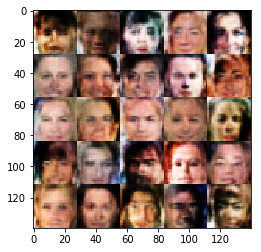

Epoch 1/1...steps:1020 Discriminator Loss: 0.3704... Generator Loss: 4.7896
Epoch 1/1...steps:1040 Discriminator Loss: 0.4221... Generator Loss: 5.7339
Epoch 1/1...steps:1060 Discriminator Loss: 0.9566... Generator Loss: 5.5003
Epoch 1/1...steps:1080 Discriminator Loss: 0.3721... Generator Loss: 4.3637
Epoch 1/1...steps:1100 Discriminator Loss: 0.8000... Generator Loss: 1.2079


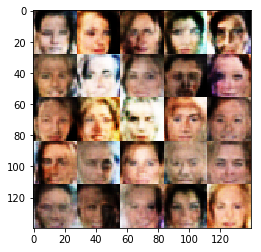

Epoch 1/1...steps:1120 Discriminator Loss: 0.4909... Generator Loss: 2.4541
Epoch 1/1...steps:1140 Discriminator Loss: 0.4699... Generator Loss: 3.3573
Epoch 1/1...steps:1160 Discriminator Loss: 0.5546... Generator Loss: 5.3503
Epoch 1/1...steps:1180 Discriminator Loss: 0.8633... Generator Loss: 4.9721
Epoch 1/1...steps:1200 Discriminator Loss: 0.4333... Generator Loss: 3.9981


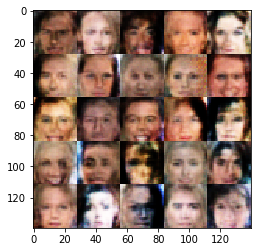

Epoch 1/1...steps:1220 Discriminator Loss: 1.0706... Generator Loss: 0.8223
Epoch 1/1...steps:1240 Discriminator Loss: 0.5577... Generator Loss: 5.4677
Epoch 1/1...steps:1260 Discriminator Loss: 0.6618... Generator Loss: 2.3439
Epoch 1/1...steps:1280 Discriminator Loss: 0.5209... Generator Loss: 2.7596
Epoch 1/1...steps:1300 Discriminator Loss: 0.8442... Generator Loss: 1.2398


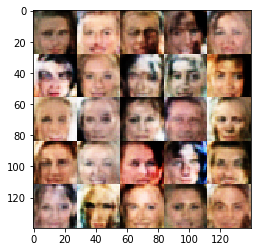

Epoch 1/1...steps:1320 Discriminator Loss: 0.4400... Generator Loss: 3.9767
Epoch 1/1...steps:1340 Discriminator Loss: 0.6122... Generator Loss: 1.9042
Epoch 1/1...steps:1360 Discriminator Loss: 0.4840... Generator Loss: 7.0104
Epoch 1/1...steps:1380 Discriminator Loss: 0.5201... Generator Loss: 2.5420
Epoch 1/1...steps:1400 Discriminator Loss: 0.7888... Generator Loss: 1.3330


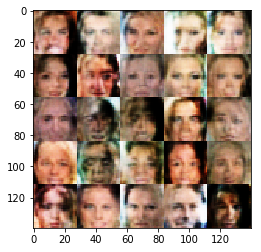

Epoch 1/1...steps:1420 Discriminator Loss: 0.6347... Generator Loss: 4.4260
Epoch 1/1...steps:1440 Discriminator Loss: 0.4447... Generator Loss: 3.3452
Epoch 1/1...steps:1460 Discriminator Loss: 0.9005... Generator Loss: 6.5095
Epoch 1/1...steps:1480 Discriminator Loss: 0.4964... Generator Loss: 2.7165
Epoch 1/1...steps:1500 Discriminator Loss: 0.4230... Generator Loss: 3.6094


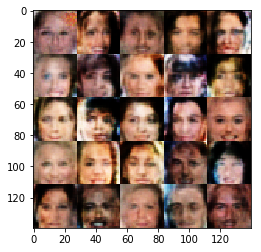

Epoch 1/1...steps:1520 Discriminator Loss: 0.6220... Generator Loss: 4.3233
Epoch 1/1...steps:1540 Discriminator Loss: 0.6189... Generator Loss: 5.3416
Epoch 1/1...steps:1560 Discriminator Loss: 0.4671... Generator Loss: 3.6997
Epoch 1/1...steps:1580 Discriminator Loss: 0.4856... Generator Loss: 2.8669
Train Finished!


In [65]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。